In [22]:
import numpy as np
import os
import matplotlib.pyplot as plt
from sklearn import cross_validation
from sklearn.metrics import classification_report, confusion_matrix
from lstm_architecture import one_hot, run_with_config

# network config

In [23]:
class Config(object):
    """
    define a class to store parameters,
    the input should be feature mat of training and testing
    """

    def __init__(self, X_train, X_test):
        # Data shaping
        self.train_count = len(X_train)  # 160000 training series
        self.test_data_count = len(X_test)  # 40000 testing series
        self.n_steps = len(X_train[0])  # 14 time_steps per series
        self.n_classes = 14  # Final output classes

        # Training
        self.learning_rate = 0.0001
        self.lambda_loss_amount = 0.005
        self.training_epochs = 1000
        self.batch_size = 128
        self.clip_gradients = 15.0
        self.gradient_noise_scale = None
        # Dropout is added on inputs and after each stacked layers (but not
        # between residual layers).
        self.keep_prob_for_dropout = 0.85  # **(1/3.0)

        # Linear+relu structure
        self.bias_mean = 0.3
        # I would recommend between 0.1 and 1.0 or to change and use a xavier
        # initializer
        self.weights_stddev = 0.2

        ########
        # NOTE: I think that if any of the below parameters are changed,
        # the best is to readjust every parameters in the "Training" section
        # above to properly compare the architectures only once optimised.
        ########

        # LSTM structure
        # Features count is of 9: three 3D sensors features over time
        self.n_inputs = len(X_train[0][0])
        self.n_hidden = 128  # nb of neurons inside the neural network
        # Use bidir in every LSTM cell, or not:
        self.use_bidirectionnal_cells = False

        # High-level deep architecture
        self.also_add_dropout_between_stacked_cells = False 

# load data

In [ ]:
def load_X(X_path):
    X_list = []
    file = open(X_path, 'r')
    # Read dataset from disk, dealing with text files' syntax
    X_signal = [np.array(item, dtype=np.float32) for item in [
               line.strip().split('\t') for line in file]]
    X_list.append(X_signal)
    file.close()
    return np.transpose(np.array(X_list), (1, 2, 0))


# Load "y" (the neural network's training and testing outputs)
def load_y(y_path):
    file = open(y_path, 'r')
    # Read dataset from disk, dealing with text file's syntax
    y_ = np.array([elem for elem in [line.strip().split('\t') for line in file]], 
                  dtype=np.int32)
    file.close()
    # Substract 1 to each output class for friendly 0-based indexing
    return one_hot(y_)

labels = {'0':'file', '1':'network', '2':'service', '3':'database', '4':'communication', '5':'memory', '6':'driver', 
    '7':'system', '8':'application', '9':'io', '10':'others', '11':'security', '12':'disk', '13':'processor'}

dataset_path = "data_msg_type/"
X_path = dataset_path + "x.txt"
y_path = dataset_path + "y.txt"

X = load_X(X_path)
y = load_y(y_path)

# Separate our training data into test and training.
print("Separating data into 80% training set & 20% test set...")
X_train, X_test, y_train, y_test = cross_validation.train_test_split(
    X, y, test_size=0.2, random_state=33)#add random state here...
print("Dataset separated.\n")

print(X_train.shape, y_train.shape, y_test.shape)

Separating data into 80% training set & 20% test set...
Dataset separated.

((160000, 14, 1), (160000, 14), (40000, 14))


# train and test

In [ ]:
n_layers_in_highway = 0
n_stacked_layers = 3
trial_name = "{}x{}".format(n_layers_in_highway, n_stacked_layers)

for learning_rate in [0.001]:  # [0.01, 0.007, 0.001, 0.0007, 0.0001]:
    for lambda_loss_amount in [0.005]:
        for clip_gradients in [15.0]:
            print "learning_rate: {}".format(learning_rate)
            print "lambda_loss_amount: {}".format(lambda_loss_amount)
            print ""

            class EditedConfig(Config):
                def __init__(self, X, Y):
                    super(EditedConfig, self).__init__(X, Y)

                    # Edit only some parameters:
                    self.learning_rate = learning_rate
                    self.lambda_loss_amount = lambda_loss_amount
                    self.clip_gradients = clip_gradients
                    # Architecture params:
                    self.n_layers_in_highway = n_layers_in_highway
                    self.n_stacked_layers = n_stacked_layers

            # # Useful catch upon looping (e.g.: not enough memory)
            # try:
            #     accuracy_out, best_accuracy = run_with_config(EditedConfig)
            # except:
            #     accuracy_out, best_accuracy = -1, -1
            accuracy_out, best_accuracy, f1_score_out, best_f1_score = (
                run_with_config(EditedConfig, X_train, y_train, X_test, y_test)
            )
            print (accuracy_out, best_accuracy, f1_score_out, best_f1_score)

            with open('{}_result_.txt'.format(trial_name), 'a') as f:
                f.write(str(learning_rate) + ' \t' + str(lambda_loss_amount) + \
                        ' \t' + str(clip_gradients) + ' \t' + str(accuracy_out) + \
                        ' \t' + str(best_accuracy) + ' \t' + str(f1_score_out) + \
                        ' \t' + str(best_f1_score) + '\n\n')

            print "______________________________________"
        print ""
print "Done."

learning_rate: 0.001
lambda_loss_amount: 0.005

Some useful info to get an insight on dataset's shape and normalisation:
features shape, labels shape, each features mean, each features standard deviation
((40000, 14, 1), (40000, 14), 0.11178214, 0.41461828)
the dataset is therefore properly normalised, as expected.
(14, ?, 1)
(?, 1)
(14, '(?, 1)')

Creating hidden #1:
(14, '(?, 128)')

Creating hidden #2:
(14, '(?, 128)')

Creating hidden #3:
(14, '(?, 128)')

Unregularised variables:
LSTM_network/layer_1/relu_fc_biases_noreg:0
LSTM_network/layer_2/relu_fc_biases_noreg:0
LSTM_network/layer_3/relu_fc_biases_noreg:0
LSTM_network/relu_fc_biases_noreg:0
iter: 0, train loss: 0.467014074326, train accuracy: 0.8984375, train F1-score: 0.870456263396, test loss: 0.343873798847, test accuracy: 0.927174210548, test F1-score: 0.896819285876
iter: 1, train loss: 0.393306732178, train accuracy: 0.9296875, train F1-score: 0.89816604812, test loss: 0.285246133804, test accuracy: 0.957024037838, test 

# confusion matrix

               precision    recall  f1-score   support

     security       1.00      1.00      1.00       279
       others       1.00      1.00      1.00      3115
    processor       1.00      1.00      1.00      5774
         disk       1.00      1.00      1.00        16
      network       1.00      1.00      1.00       248
         file       1.00      1.00      1.00     29818
     database       1.00      1.00      1.00        64
      service       1.00      1.00      1.00       479
       memory       1.00      1.00      1.00       207

  avg / total       1.00      1.00      1.00     40000

[[  279     0     0     0     0     0     0     0     0]
 [    0  3115     0     0     0     0     0     0     0]
 [    0     0  5774     0     0     0     0     0     0]
 [    0     0     0    16     0     0     0     0     0]
 [    0     0     0     0   248     0     0     0     0]
 [    0     0     0     0     0 29818     0     0     0]
 [    0     0     0     0     0     0    64     0 

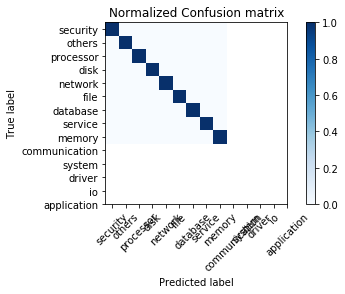

In [21]:
def plot_confusion_matrix(cm, title='Normalized Confusion matrix', 
                          cmap=plt.cm.get_cmap("Blues")): 
    cm = cm / cm.astype(np.float).sum(axis=1) 
    #print "confusion_matrix: \n{}".format(cm) 
    plt.imshow(cm, interpolation='nearest', cmap=cmap) 
    plt.title(title) 
    plt.colorbar() 
    tick_marks =np.arange(len(labels))
    plt.xticks(tick_marks, labels.values(), rotation=45) 
    plt.yticks(tick_marks, labels.values()) 
    plt.tight_layout() 
    plt.ylabel('True label') 
    plt.xlabel('Predicted label') 
    plt.show()

def test_(): 
    y_true = np.load("data/y_true.npy") 
    y_pred = np.load("data/y_pred.npy") 
    print(classification_report(y_true, y_pred, 
          target_names = labels.values()))
    print(confusion_matrix(y_true, y_pred))
    print()
    plot_confusion_matrix(confusion_matrix(y_true, y_pred))

if __name__ == "__main__":
    test_()